# Analyzing actions between models of different Eureka iterations

## Data format
example data format of variables and their shapes:
```
pre_norm_obs
(499, 64, 23)
post_norm_obs
(499, 64, 23)
mu
(499, 64, 9)
logstd
(499, 64, 9)
value
(499, 64, 1)
```
where the dimensions indicate (time, batch, actual_dim)

## Visualization
we can fix an index within the batch and plot the time series of various variables/dimensions.
Use matplotlib

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
WEAK_MODEL_FILE = "FrankaCabinetGPT_epoch__iter0.pth"
MEDIUM_MODEL_FILE = "FrankaCabinetGPT_epoch__iter1.pth"
STRONG_MODEL_FILE = "FrankaCabinetGPT_epoch__eval.pth"

CHECKPOINT_DIR = 'ckpts/2025-02-13_09-26-08'

In [3]:
from utils.model_utils import load_model, load_data, compute_model_outputs, process_model_outputs

In [4]:
# 1. Load all three models

weak_model = load_model(WEAK_MODEL_FILE, CHECKPOINT_DIR)
medium_model = load_model(MEDIUM_MODEL_FILE, CHECKPOINT_DIR)
strong_model = load_model(STRONG_MODEL_FILE, CHECKPOINT_DIR)

# 2. Load all trajectory data
weak_data = load_data(WEAK_MODEL_FILE, CHECKPOINT_DIR)
medium_data = load_data(MEDIUM_MODEL_FILE, CHECKPOINT_DIR)
strong_data = load_data(STRONG_MODEL_FILE, CHECKPOINT_DIR)

Loading model from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__iter0_dill.pkl
Model loaded successfully! Type: Network
Loading model from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__iter1_dill.pkl
Model loaded successfully! Type: Network
Loading model from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__eval_dill.pkl
Model loaded successfully! Type: Network
Loading data from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__iter0.npz
Loading data from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__iter1.npz
Loading data from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__eval.npz


In [4]:
print("\nLoaded data shapes:")
for name, data in [("Weak", weak_data), ("Medium", medium_data), ("Strong", strong_data)]:
    print(f"{name} model data:")
    for key in data.files:
        print(f"  {key}: {data[key].shape}")


Loaded data shapes:
Weak model data:
  pre_norm_obs: (499, 64, 23)
  post_norm_obs: (499, 64, 23)
  mu: (499, 64, 9)
  logstd: (499, 64, 9)
  value: (499, 64, 1)
Medium model data:
  pre_norm_obs: (499, 64, 23)
  post_norm_obs: (499, 64, 23)
  mu: (499, 64, 9)
  logstd: (499, 64, 9)
  value: (499, 64, 1)
Strong model data:
  pre_norm_obs: (58, 64, 23)
  post_norm_obs: (58, 64, 23)
  mu: (58, 64, 9)
  logstd: (58, 64, 9)
  value: (58, 64, 1)


## Exploratory
Explore each model's outputs given its own observations

In [28]:
def unwrap_data(data):
    return data['pre_norm_obs'], data['mu'], data['value']

In [29]:
obs_strong_original, mu_strong_original, value_strong_original = unwrap_data(strong_data)
obs_medium_original, mu_medium_original, value_medium_original = unwrap_data(medium_data)
obs_weak_original, mu_weak_original, value_weak_original = unwrap_data(weak_data)

In [30]:
mu_strong_original_clipped, value_strong_original_denorm = process_model_outputs(
    mu_strong_original, 
    value_strong_original, 
    strong_model,
)

In [31]:
mu_medium_original_clipped, value_medium_original_denorm = process_model_outputs(
    mu_medium_original, 
    value_medium_original, 
    medium_model
)

In [32]:
mu_weak_original_clipped, value_weak_original_denorm = process_model_outputs(
    mu_weak_original, 
    value_weak_original, 
    weak_model
)

In [33]:
clipped_mu_list = [
    mu_strong_original_clipped, 
    mu_medium_original_clipped, 
    mu_weak_original_clipped
]

In [43]:
obs_list = [
    obs_strong_original,
    obs_medium_original,
    obs_weak_original
]

In [34]:
labels = ["Strong", "Medium", "Weak"]

In [35]:
from utils.plots import plot_action_trajectories

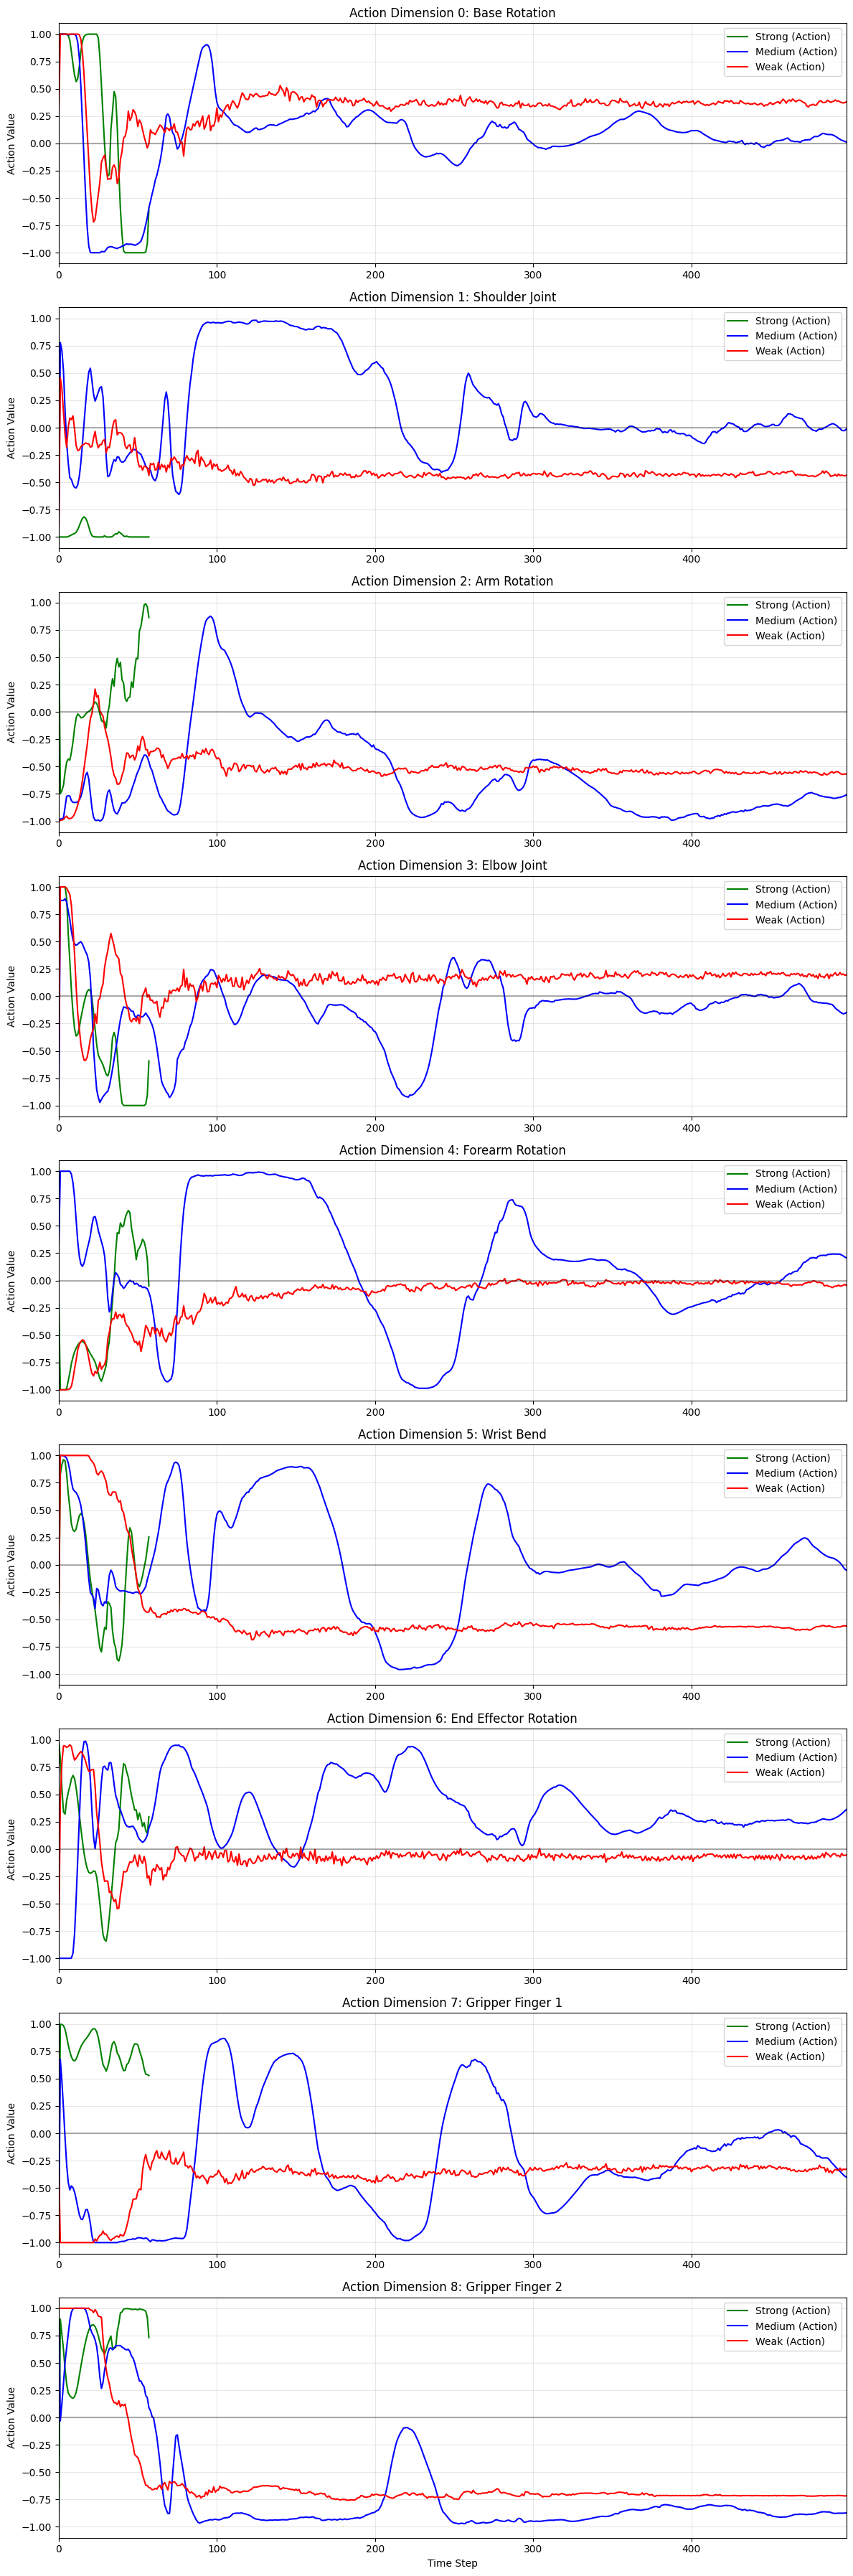

In [41]:
# average actions across all actors
plot_action_trajectories(
    clipped_mu_list,
    labels=labels,
)

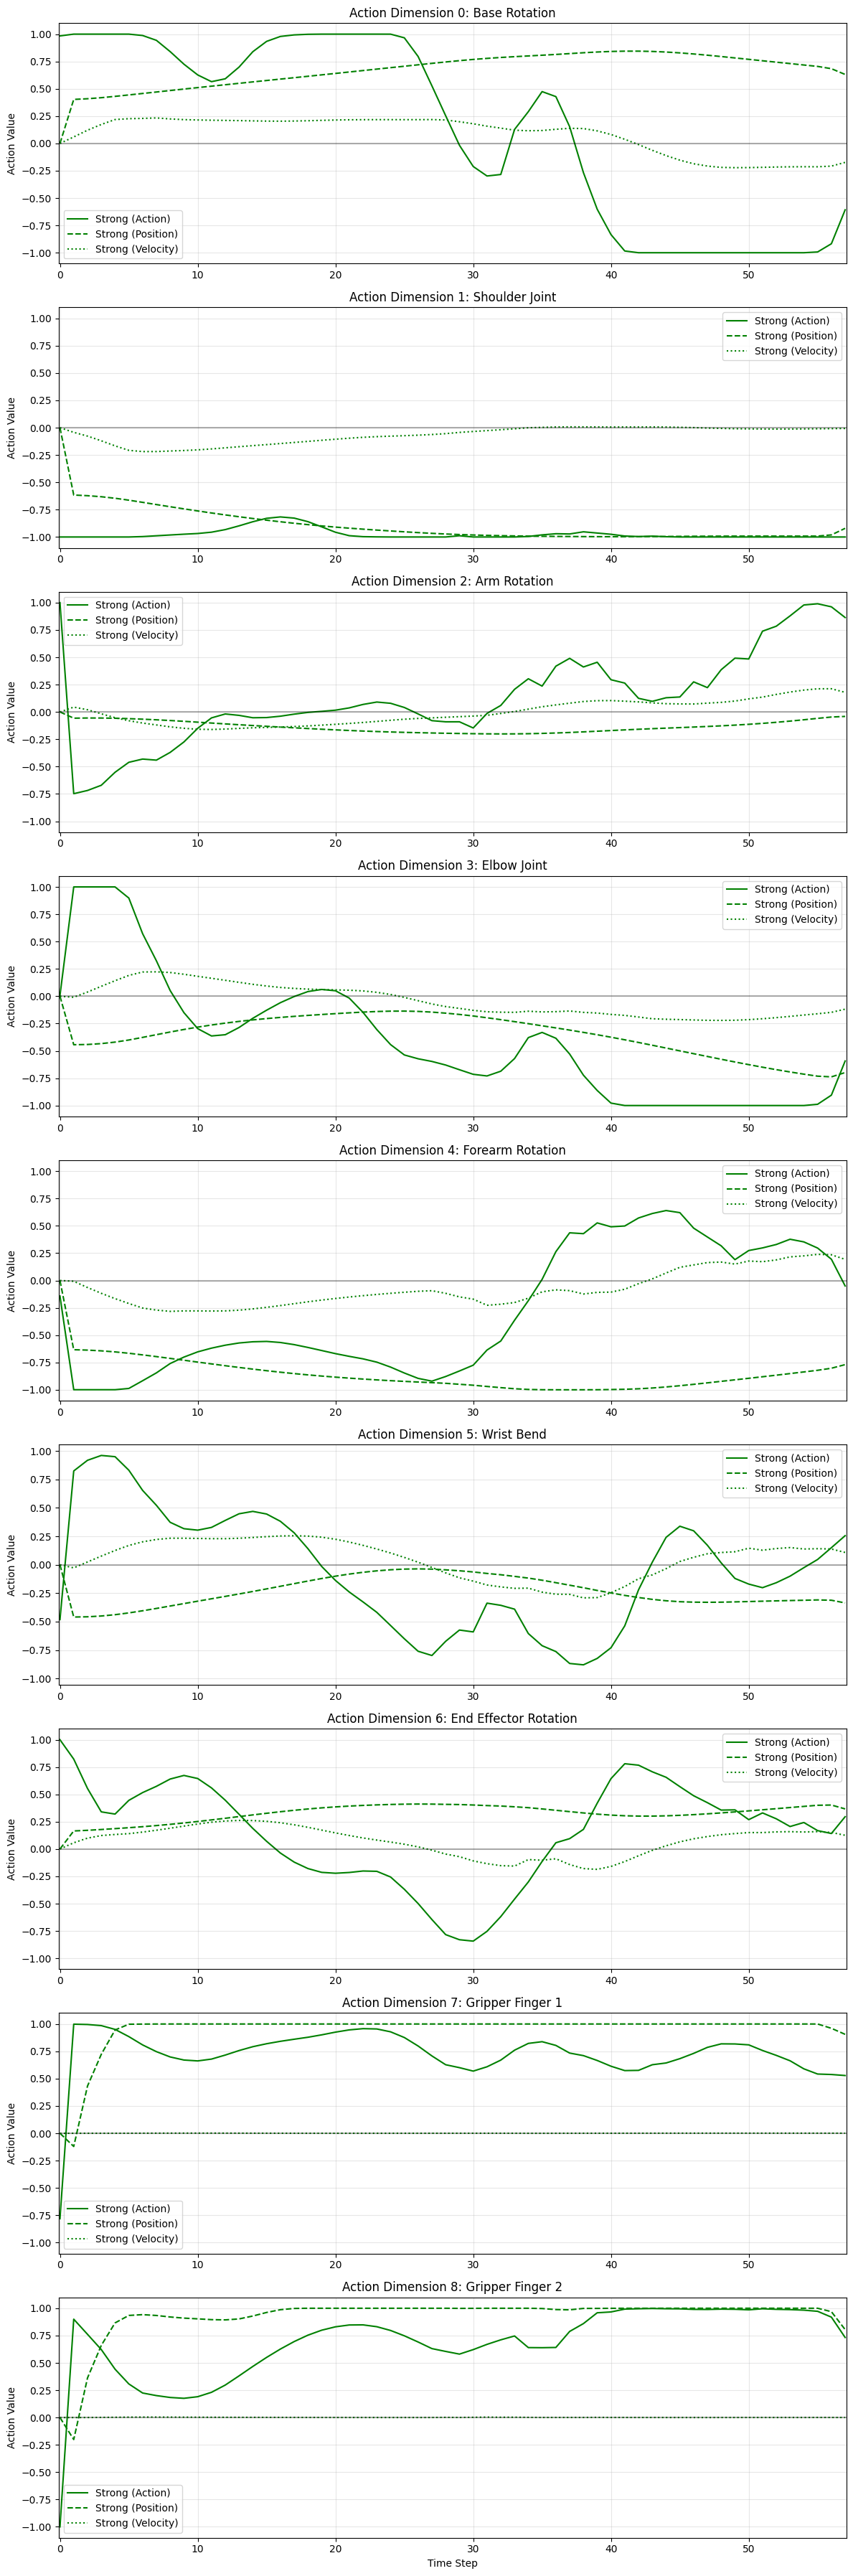

In [47]:
# plot strong alone to zoom in
plot_action_trajectories(
    [mu_strong_original_clipped],
    obs_list=[obs_strong_original],
    labels=["Strong"],
)

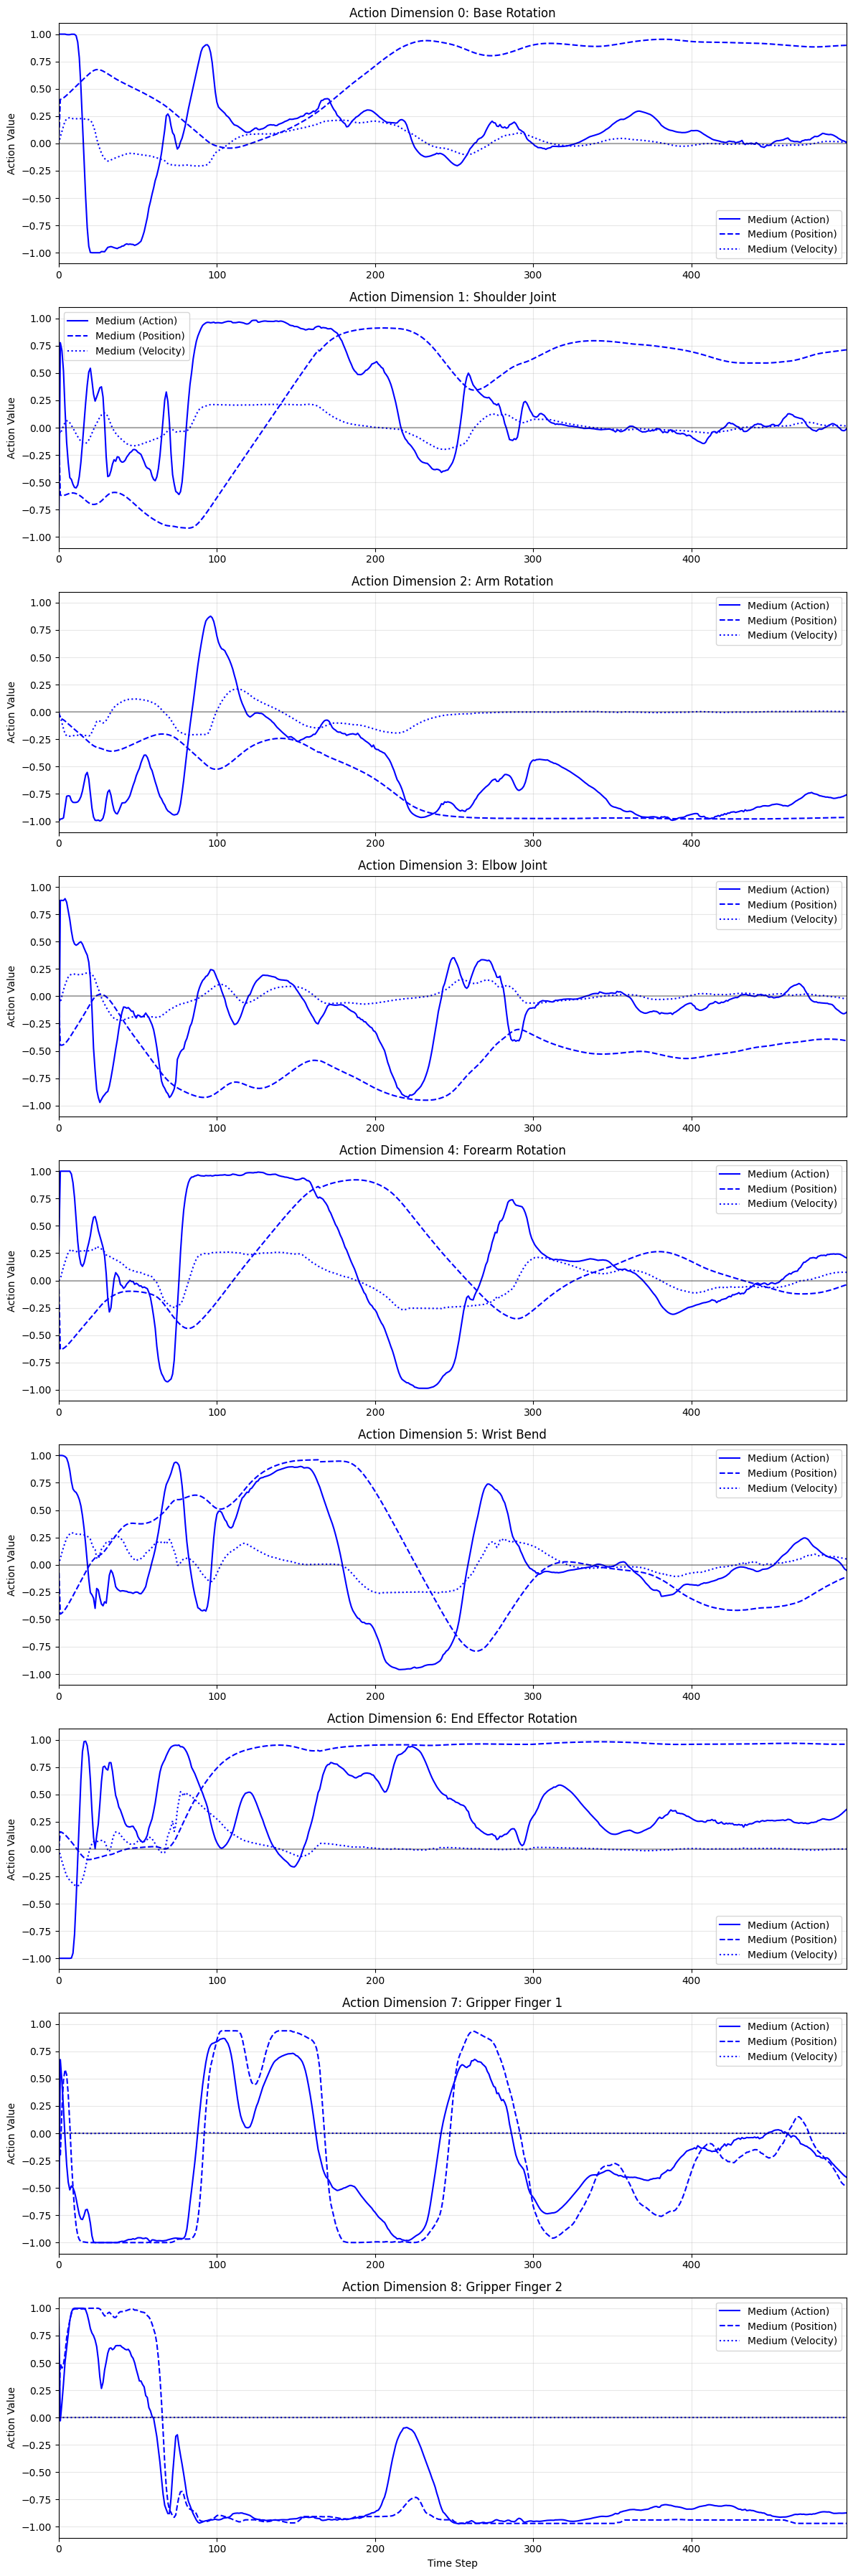

In [49]:
plot_action_trajectories(
    [mu_medium_original_clipped],
    obs_list=[obs_medium_original],
    labels=["Medium"],
    colors=["b"],
)

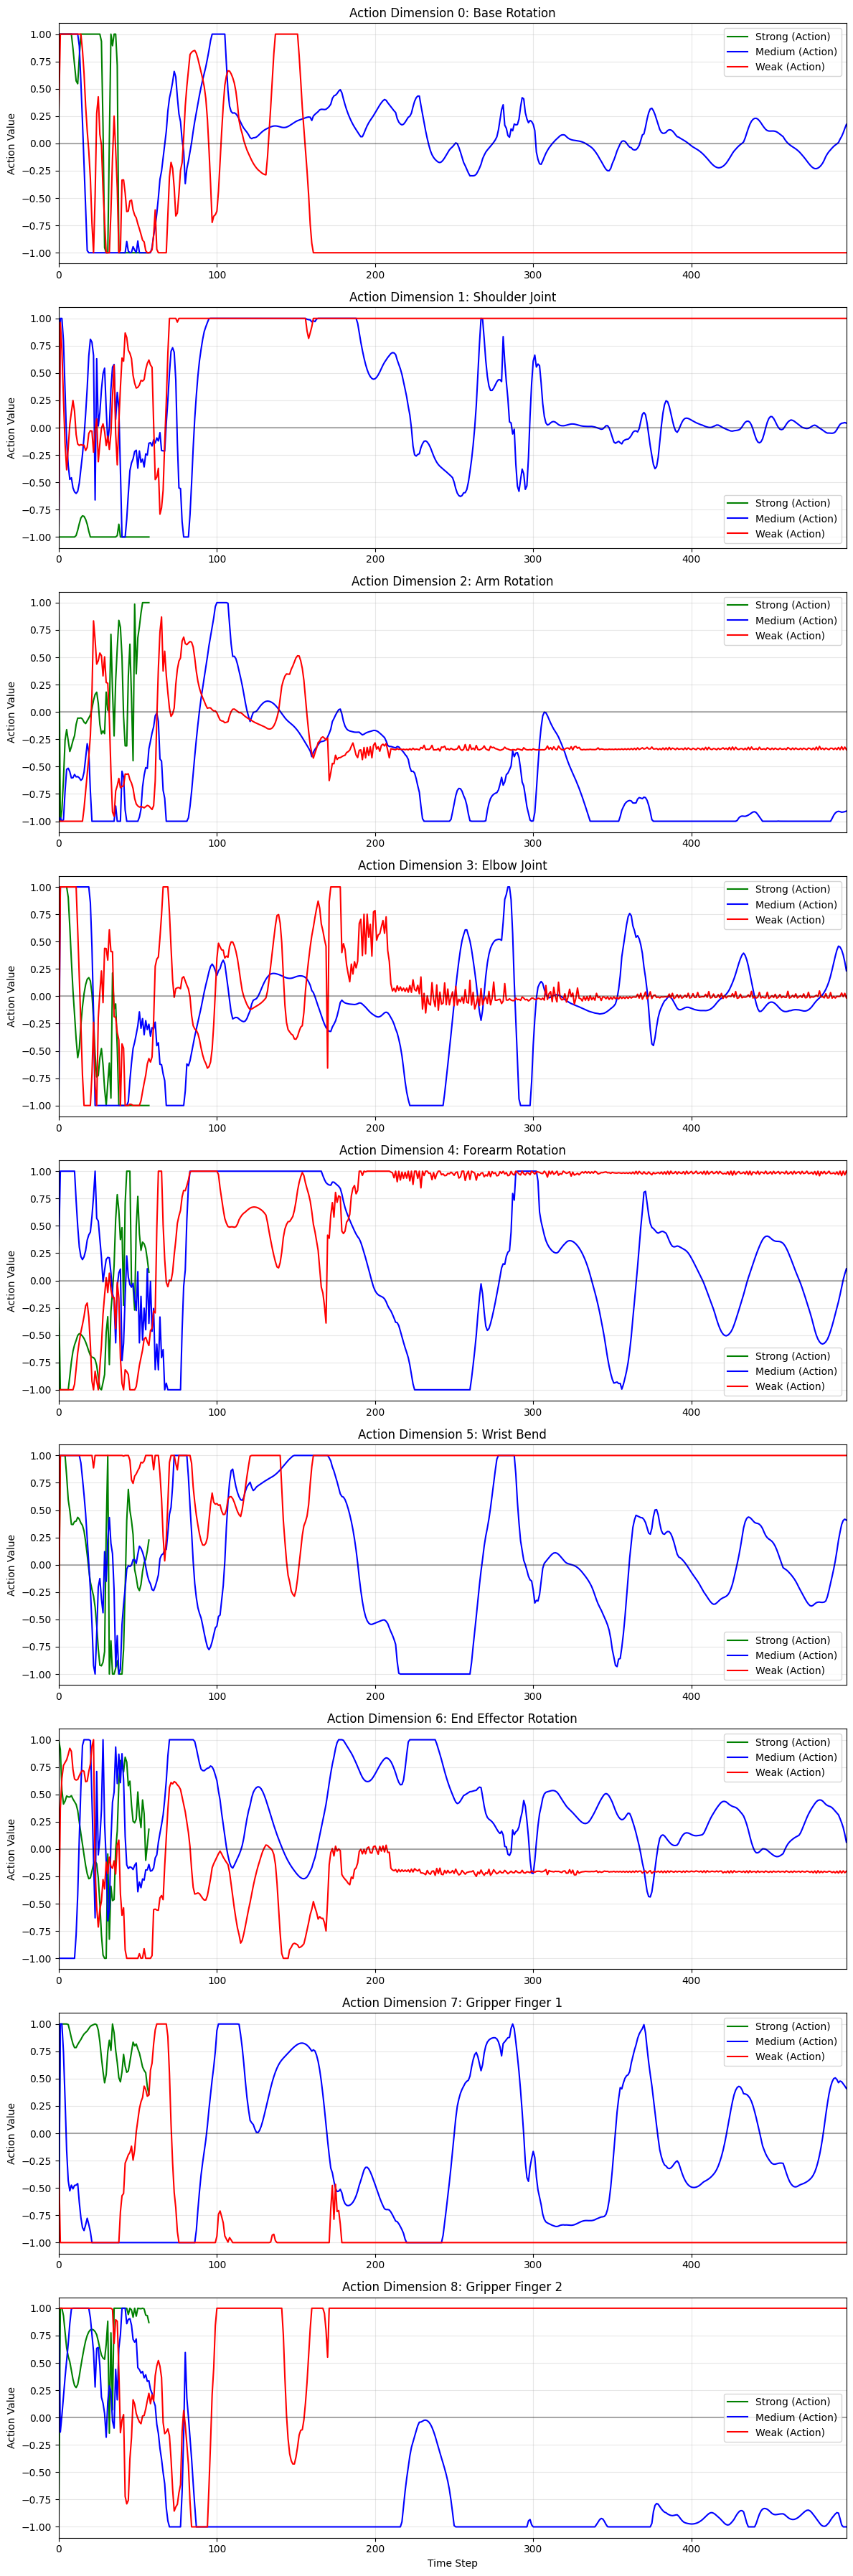

In [45]:
# choose specific actor
plot_action_trajectories(
    clipped_mu_list,
    labels=labels,
    actor_idx=0,
)

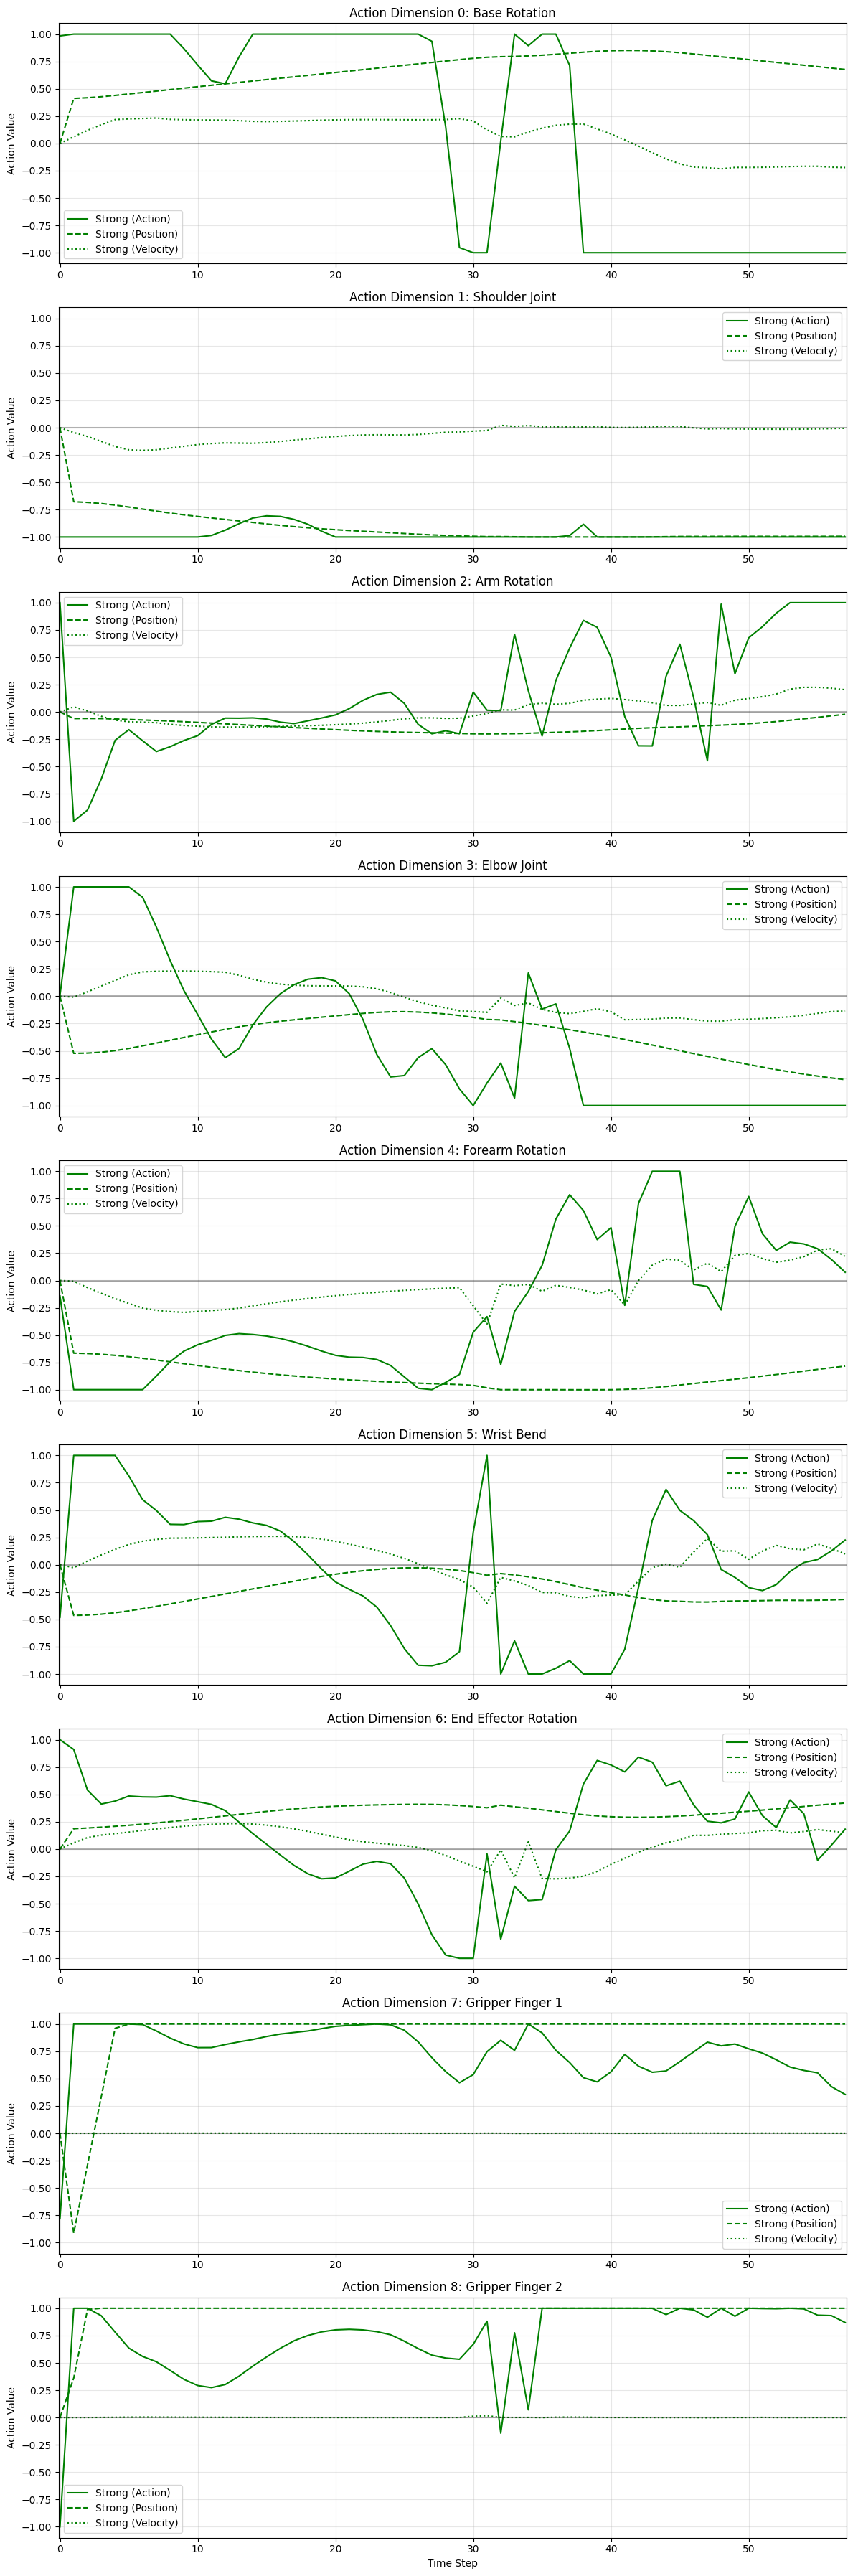

In [46]:
plot_action_trajectories(
    [mu_strong_original_clipped],
    obs_list=[obs_strong_original],
    labels=["Strong"],
    actor_idx=0,
)

### Visualizing joints via phases
#### Strong model only

In [60]:
from utils.data_transforms import get_all_phase_masks, segment_observation

In [57]:
joint_positions, joint_velocities, rel_pos_to_handle, drawer_position, drawer_velocity = segment_observation(obs_strong_original)

In [58]:
approaching_mask, approaching_count, opening_mask, opening_count, deceleration_mask, deceleration_count = get_all_phase_masks(drawer_position, drawer_velocity)

In [59]:
print(f"Approaching count: {approaching_count}")
print(f"Opening count: {opening_count}")
print(f"Deceleration count: {deceleration_count}")


Approaching count: 1914
Opening count: 1191
Deceleration count: 474


In [72]:
from utils.plots import plot_joint_velocities_vs_distance

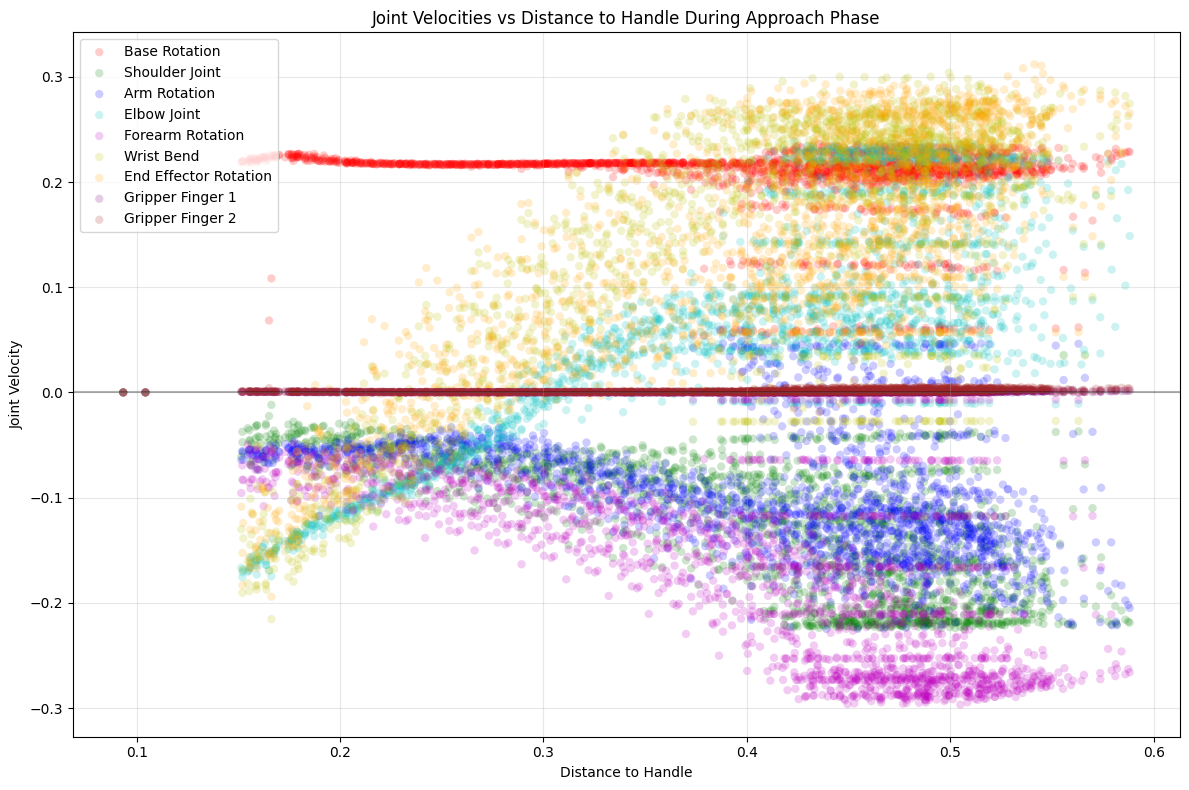

In [76]:
plot_joint_velocities_vs_distance(joint_velocities, rel_pos_to_handle, approaching_mask)

In [67]:
from utils.plots import plot_joint_velocities_stats_by_distance

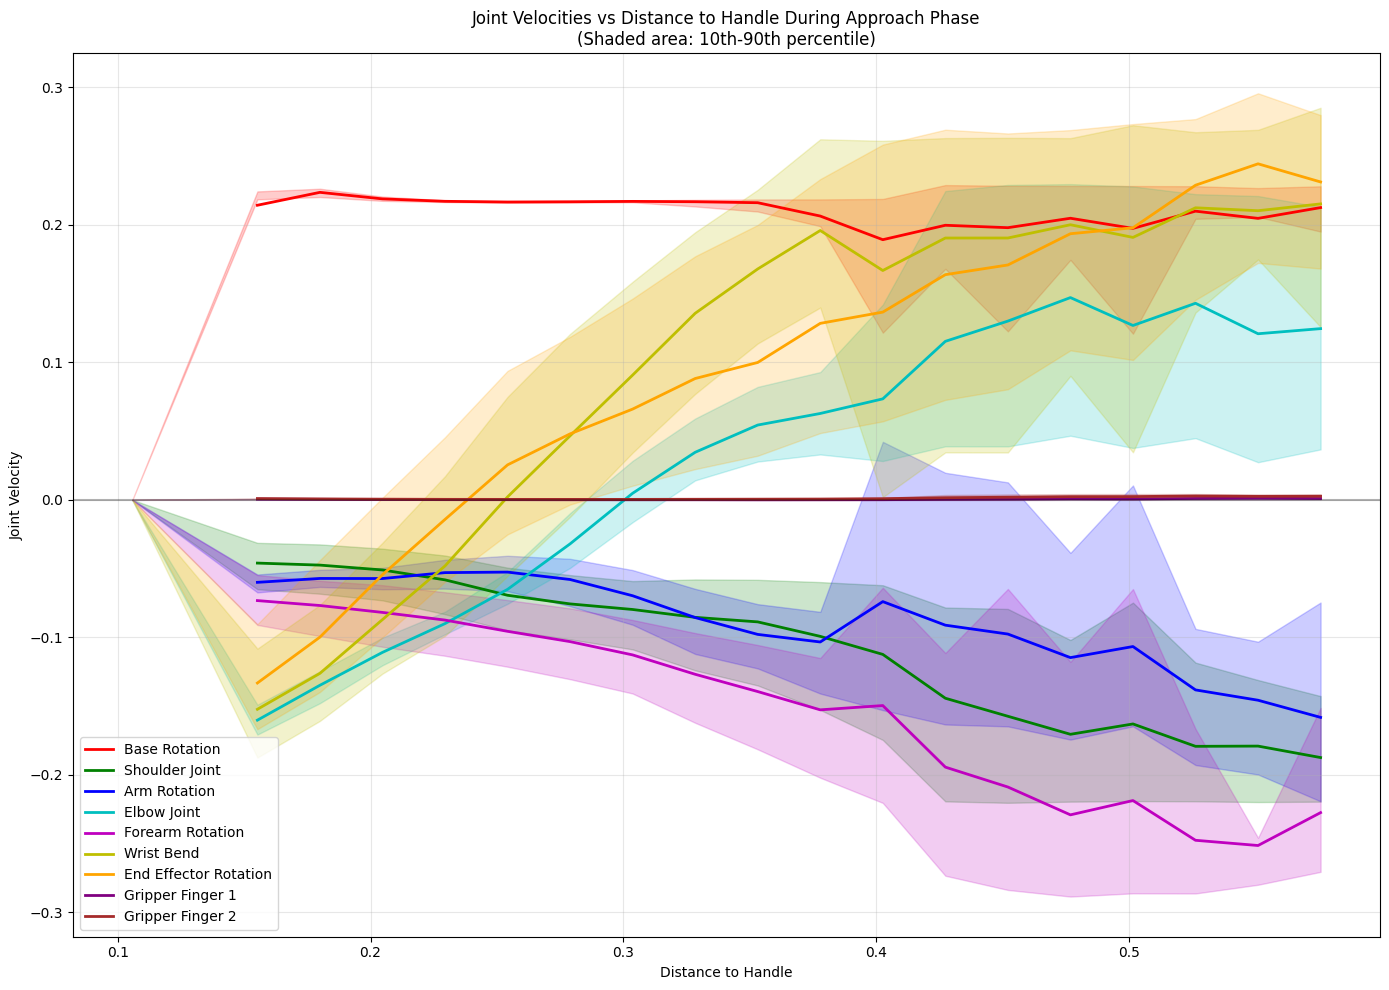

In [69]:
plot_joint_velocities_stats_by_distance(joint_velocities, rel_pos_to_handle, approaching_mask)

#### Comparison across models, in phases
##### Approach phase
This is when the model is moving its arm towards the handle, characterized by both drawer_position and drawer_velocity being close to 0.

In [77]:
from utils.plots import compare_joint_velocities_across_models

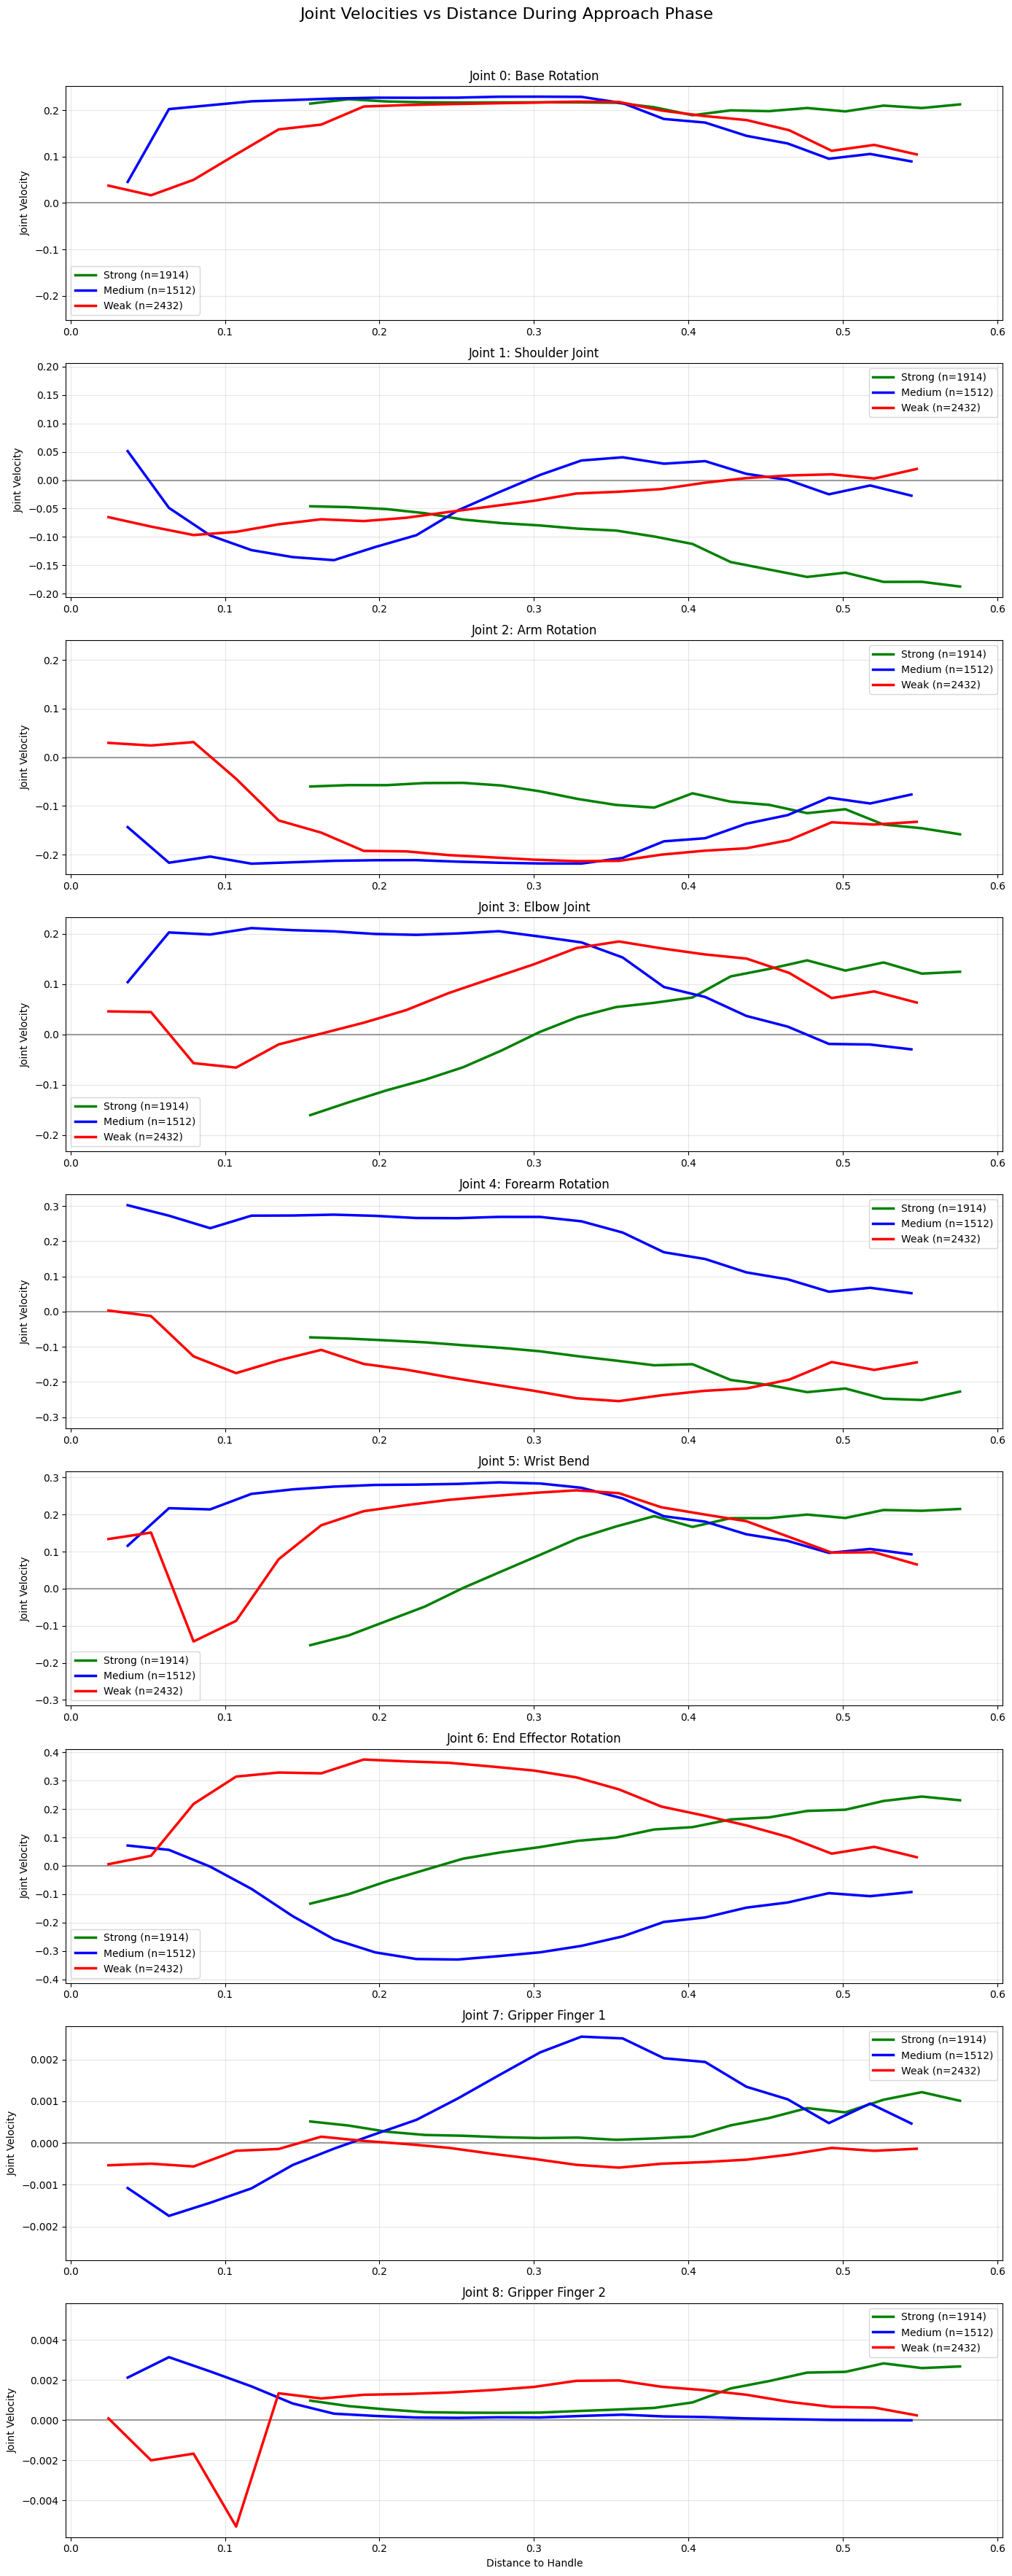

In [80]:
compare_joint_velocities_across_models(
    obs_list=[obs_strong_original, obs_medium_original, obs_weak_original],
    labels=["Strong", "Medium", "Weak"],
)

##### Opening phase
This is when the model is exerting force on the handle to open it, characterized by drawer_velocity being positive and acceleration being positive.

Function already written, just need to plot joint velocities wrt drawer_velocity

##### Deceleration phase
This is when the model/friction is slowing down its arm to stop at the handle, characterized by drawer_velocity being positive and acceleration being negative.

Function already written, just need to plot joint velocities wrt drawer_velocity


### Qualitative analysis
#### Generic visual trend
- Strong model moves in without fully extending its arm, hooks handle, pulls it, episode ends
- Medium model moves in and extends arm quite substantially, grips handle, pulls it, episode doesnt end as the drawer is not open wide enough, arm fidgets a lot afterwards
- Weak model moves in and extends arm quite substantially, fine adjustment towards handle, attempts to grip handle but fails in overall contact and stips moving.
#### Relating visual trend to graphs
- Note: bulk of the main actions happen within the first 100 timesteps
- Strong model aims to hook the cabinet handle while the medium and weak model attempt to grip the handle
    - Grippers fingers have negative values for the models that attempt to grip, while the strong model has positive values as it doesnt need to adjust its grip